# The OpenPV Project Data Analysis

The Open PV (PhotoVoltaic) project is an effort by the National Renewable Energy Laboratory (NREL) to compile a database of photovoltaic (PV) installations across the United States by collaborating with government, industry, and the public.  The database can be found at https://openpv.nrel.gov/search and it consists of over 1 million unique installations across all fifty state and spanning two decades.  The database has a combination of quantitative and categorical features.  My goal for this project is to determine which states would be the best to target for federal rebates in order to best grow the photovoltaic capacity of the country.  

In [60]:
import pandas
import numpy
import datetime
import sklearn
import matplotlib.pyplot as pyplot



In [ ]:
df = pandas.read_csv('openpv_all.csv',engine='python')
df['date'] = pandas.to_datetime(df['date_installed']).apply(lambda dt: dt.replace(day=15))
df['year'] = df['date_installed'].str.slice(-4).astype(float)
df['count'] = 1.
df['rebates']=df['rebate'].str.strip('$-').str.replace(',','').astype(float)
df['pct_reported_prod'] = 100*df.reported_annual_energy_prod/df.annual_PV_prod
df['install_type'] = df['install_type'].str.lower().str.split().str[0]
df['state'] = df['state'].str.strip()

stateinsol = pandas.read_csv('stateinsolations.csv')
stateinsol.head()

def NewInsol(x):
    if numpy.isnan(x['annual_insolation']):
        temp_ = stateinsol[(stateinsol['StateID'] == x['state'])]['Insolation']
        return temp_.item()
         
    else:
        return x['annual_insolation']
df['new_insolation'] = df[['annual_insolation','state']].apply(NewInsol,axis=1)

In [61]:
subdf = df.loc[:,['state','size_kw','install_type','cost_per_watt','cost','annual_PV_prod','new_insolation',
                'reported_annual_energy_prod','date','count','rebates','pct_reported_prod']]
subdf.head()

,state,size_kw,install_type,cost_per_watt,cost,annual_PV_prod,new_insolation,reported_annual_energy_prod,date,count,rebates,pct_reported_prod
0,TX,10.560,residential,2.897777,30600.53,14999.831600,5.157692,13836.0,2013-12-15,1.0,15000.0,92.241036
1,TX,12.720,residential,3.144654,40000.00,17811.574390,5.085633,16419.0,2014-07-15,1.0,15000.0,92.181632
2,TX,5.400,residential,4.197330,22665.58,7833.742822,5.262714,7235.0,2014-01-15,1.0,7735.5,92.356874
3,IN,6.785,residential,2.590000,17550.00,NaN,4.560000,NaN,2017-10-15,1.0,NaN,NaN
4,IN,4.720,residential,2.570000,12150.00,NaN,4.560000,NaN,2017-10-15,1.0,NaN,NaN


The focus will be on residential installations and the database is pared down to the most prominant and numerically quantifiable parameters.  

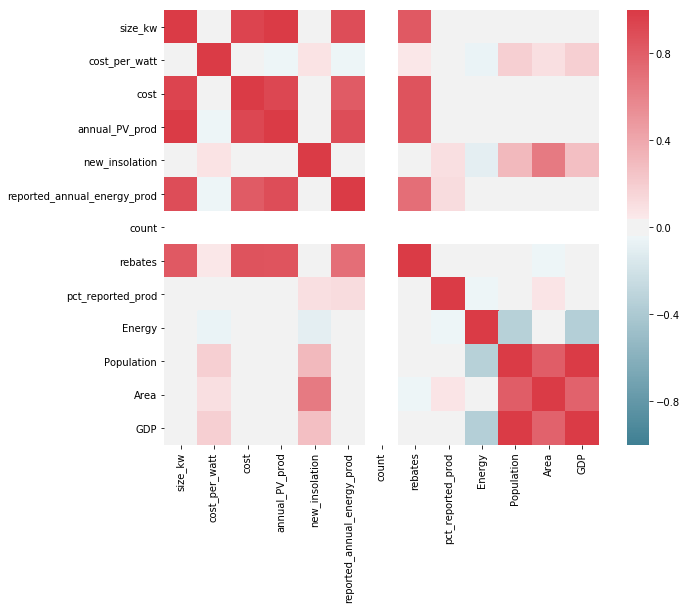

In [91]:
import seaborn as sns

f, ax = pyplot.subplots(figsize=(10, 8))
corr = subdf.corr()
sns.heatmap(corr, mask=numpy.zeros_like(corr, dtype=numpy.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax,vmin=-1, vmax=1)

A correlation matrix of the parameters shows how some of the features.  Below is a function to display a map of the united states in order to visualize the data.

In [2]:
from bokeh.layouts import layout
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.palettes import Magma256 as palette
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper, LogTicker, ColorBar

def BokehMap(dict_data,d_min, d_max,title_str,cb_str):
    us_states = numpy.load('us_states.npy').item()
    
#    us_counties = us_counties.data.copy()
#    unemployment = unemployment.data
    
    del us_states["HI"]
    del us_states["AK"]
    #del dict_data["HI"]
    #del dict_data["AK"]
    
    state_xs = [us_states[code]["lons"] for code in us_states]
    state_ys = [us_states[code]["lats"] for code in us_states]
    
    #county_xs=[us_counties[code]["lons"] for code in us_counties if us_counties[code]["state"] not in ["ak", "hi", "pr", "gu", "vi", "mp", "as"]]
    #county_ys=[us_counties[code]["lats"] for code in us_counties if us_counties[code]["state"] not in ["ak", "hi", "pr", "gu", "vi", "mp", "as"]]
    
    #colors = ["#F1EEF6", "#D4B9DA", "#C994C7", "#DF65B0", "#DD1C77", "#980043"]
    
    #county_colors = []
    state_colors = []
    state_data = []
    for state_id in us_states.keys():
    #    state_id = state_id.lower()
    #    if us_counties[county_id]["state"] in ["ak", "hi", "pr", "gu", "vi", "mp", "as"]:
    #        continue
        try:
    #        rate = numpy.nanmean([unemployment[code] for code in us_counties
    #                             if us_counties[code]['state']==state_id])
            data = dict_data[state_id]
    #        print state_id, data
            state_data.append(data)
    #        state_colors.append(colors[idx])
        except KeyError:
    #        state_colors.append("black")
            state_data.append(0.0)
    
#    output_file("choropleth.html", title="choropleth.py example")
#    output_notebook()
    #palette.reverse()
    color_mapper = LogColorMapper(palette=palette, low = d_min, high = d_max)
    
    source = ColumnDataSource(data=dict(
        x=state_xs,
        y=state_ys,
        name=us_states.keys(),
        data=state_data,
    ))
    #p = figure(title="US Unemployment 2009", toolbar_location="left",
    #    plot_width=1100, plot_height=700)
    TOOLS = "pan,wheel_zoom,reset,hover,save"


    p = figure(title=title_str, tools=TOOLS,plot_width=990, plot_height=630)
#   plot_width=1100, plot_height=700
#        )
    #p.patches(county_xs, county_ys, fill_color=county_colors, fill_alpha=0.7,
    #    line_color="white", line_width=0.5)
    #p.patches(state_xs, state_ys,source=source, fill_color=state_colors,fill_alpha=0.7,
    #    line_color="#884444", line_width=2)
    p.patches('x', 'y', source=source,
              fill_color={'field': 'data', 'transform': color_mapper},
              fill_alpha=1.0, line_color="#884444", line_width=1.0)

    color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(), label_standoff=12, border_line_color=None, location=(0,0))
    p.add_layout(color_bar, 'right')

    hover = p.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [
        ("Name", "@name"),
        (title_str+' ('+cb_str+')', "@data"),
        ("(Long, Lat)", "($x, $y)"),
        ]
    show(p) 

In [6]:
insol = df.groupby(['state'])['new_insolation'].mean()
insoldat = insol.to_dict()
#print insol
#print insoldat
output_notebook()
BokehMap(insoldat,3,7,'Incident Solar Radiation','')

Loading BokehJS ...

The insolation (a portmanteau of incident solar radiation) represents the annual average number of hours of solar production in day.  For example, a 1 kW solar array in California with an average insolation of 5.613 will produce 5.613 kWh (kilowatt hours) of power.  The united states uses approximatelyl *** of energy per year.

In [8]:
pvnum = df.groupby('state')['count'].sum().replace(numpy.nan,0.)
pvnumdat = pvnum.to_dict()
BokehMap(pvnumdat,1,1000000,'Number of Solar Installation','')

In [15]:
cost = df.groupby('state')['cost'].sum().replace(numpy.nan,0.)/1000000.
costdat = cost.to_dict()
BokehMap(costdat,1,10000,'Solar Investment ($M)','')

In [66]:
rebate = df.groupby('state')['rebates'].sum().replace(numpy.nan,0.)
rebatedat = rebate.to_dict()
BokehMap(rebatedat,1000,1e9,'Rebates ($)','')

We are interested in the effectiveness of rebates and so we do a linear regression across each state to figure out the relationship beween rebates and the size of a solar installation.  The slope of this line represents the number of Watts of solar capacity which were built per dollar of rebate invested.  So in this case we can see the effectiveness of rebates on encouraging people to build larger installations and see how that varies by state.  For this analysis, we focus on small (<50 kW) residential installations

In [65]:
from sklearn.linear_model import LinearRegression,Ridge

slopes = {}
for state in df['state'].value_counts().index:
    if state == 'DC' or state == 'PR':
        continue
    rdf = df[(df['install_type']=='residential')&(df['size_kw'] <= 50)&(df['state']==state)]

    data = rdf.loc[:,['rebates','cost','size_kw']].dropna()
    if data.shape[0] == 0:
        continue
    
    x = numpy.array(data['rebates']).reshape(-1,1)
    y = numpy.array(data['size_kw']).reshape(-1,1)

    linreg = Ridge(fit_intercept=False)
    line = linreg.fit(x,y)
    slopes[state] = line.coef_[0][0]*1000
print slopes.items()

[('NH', 1.3191207508539211), ('MD', 1.3658123415563248), ('NJ', 0.25249288065256881), ('MN', 0.50487928554263628), ('MA', 0.31133539510407493), ('TX', 0.48945035542833715), ('UT', 1.2187202546185978), ('CA', 0.61653223029630022), ('DE', 0.48746388292233372), ('WI', 0.69113104690938221), ('RI', 0.89097919659057612), ('NY', 0.52274964424474746), ('PA', 0.64955208648864504), ('AR', 0.33319450126319061), ('AZ', 0.46686145763055892), ('FL', 0.29026900202526024), ('OR', 0.70133784956487877), ('NV', 1.0881600337083599), ('CT', 0.3947306876106747)]


Unfortunately this can only give us information about regions that offer rebates at the state level.  There are a few states that particularly stand out at this level.  Nevada and Utah in the southwest as well as Maryland and New Hampshire in the east.  In order to fill in some information on the other states, we will do a comibination of Principal Component Analysis along with KMeans classifying to find states that are similar so we can apply one of the rebate models to those states as well.

In [67]:
BokehMap(slopes,.1,2,'Watts/Dollar (Rebates)','')

We can combine our database with some other metrics in order to classify them.  The included parameters are annual energy use, population, area, and GDP.

In [68]:
stateinfo = pandas.read_csv('stategdp.csv')
statinf = stateinfo.loc[:,['Energy','Population','Area']]
statinf['GDP'] = stateinfo['2015']
statinf['state'] = stateinfo['State']
subdf = df.loc[:,['state','size_kw','install_type','cost_per_watt','cost','annual_PV_prod','new_insolation',
                'reported_annual_energy_prod','date','count','rebates','pct_reported_prod']]
subdf = pandas.merge(subdf,statinf, on='state')
statinf.head()

,Energy,Population,Area,GDP,state
0,398.0,4780127.0,50645.33,199804,AL
1,809.0,710249.0,570640.95,52448,AK
2,213.0,6392307.0,113594.08,293318,AZ
3,354.0,2915958.0,52035.48,119081,AR
4,199.0,37252895.0,155779.22,2510167,CA


In [72]:
#kdf = subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()[['size_kw','cost','count','rebates']]
kdf = pandas.DataFrame()
kdf['size_kw'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()['size_kw']
kdf['cost'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()['cost']
kdf['count'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()['count']
#kdf['rebates'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()['rebates']
kdf['new_insolation'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['new_insolation']
kdf['Energy'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['Energy']
kdf['Population'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['Population']
kdf['Area'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['Energy']
kdf['GDP'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['GDP']
kdf.head()

,size_kw,cost,count,new_insolation,Energy,Population,Area,GDP
state,,,,,,,,
AK,4.961000e+01,8.930711e+04,12.0,3.250000,809.0,710249.0,809.0,52448
AL,5.736000e+01,3.997950e+05,13.0,5.120000,398.0,4780127.0,398.0,199804
AR,7.531960e+02,3.595872e+06,158.0,5.031776,354.0,2915958.0,354.0,119081
AZ,6.052125e+05,2.824814e+09,85498.0,6.489424,213.0,6392307.0,213.0,293318
CA,4.190918e+06,1.280277e+10,574307.0,5.610740,199.0,37252895.0,199.0,2510167


In [ ]:
#kdf = subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()[['size_kw','cost','count','rebates']]
#kdf = pandas.DataFrame()
#kdf['size_kw'] = numpy.log(subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()['size_kw'])
#kdf['cost'] = numpy.log(subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()['cost'])
#kdf['count'] = numpy.log(subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()['count'])
##kdf['rebates'] = subdf[(subdf['install_type'] == 'residential')].groupby('state').sum()['rebates']
#kdf['new_insolation'] = numpy.log(subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['new_insolation'])
#kdf['Energy'] = numpy.log(subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['Energy'])
#kdf['Population'] = numpy.log(subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['Population'])
#kdf['Area'] = numpy.log(subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['Energy'])
#kdf['GDP'] = numpy.log(subdf[(subdf['install_type'] == 'residential')].groupby('state').mean()['GDP'])


In [34]:
from sklearn.preprocessing import StandardScaler

pcadf = StandardScaler().fit_transform(kdf)

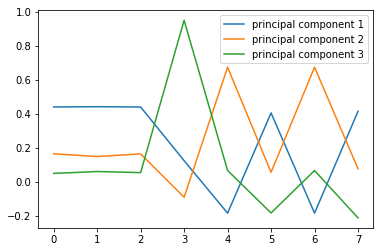

0.914974406103 [ 0.56483227  0.22994478  0.12019736]


In [70]:
from sklearn.decomposition import PCA

num = 3
pca = PCA(n_components=num)
principalComponents = pca.fit_transform(pcadf)
principalDf = pandas.DataFrame(data = pca.components_.T
             , columns = ['principal component '+str(x) for x in range(1,num+1)])
principalDf.plot()
pyplot.show()
print sum(pca.explained_variance_ratio_),pca.explained_variance_ratio_


The first component primarily focuses on the size, investment and number of solar installations along with the states population and GDP.  The second component is based mostly on the energy use and area of the state along with population.  The third component is based primarily on the incident solar radiation.  

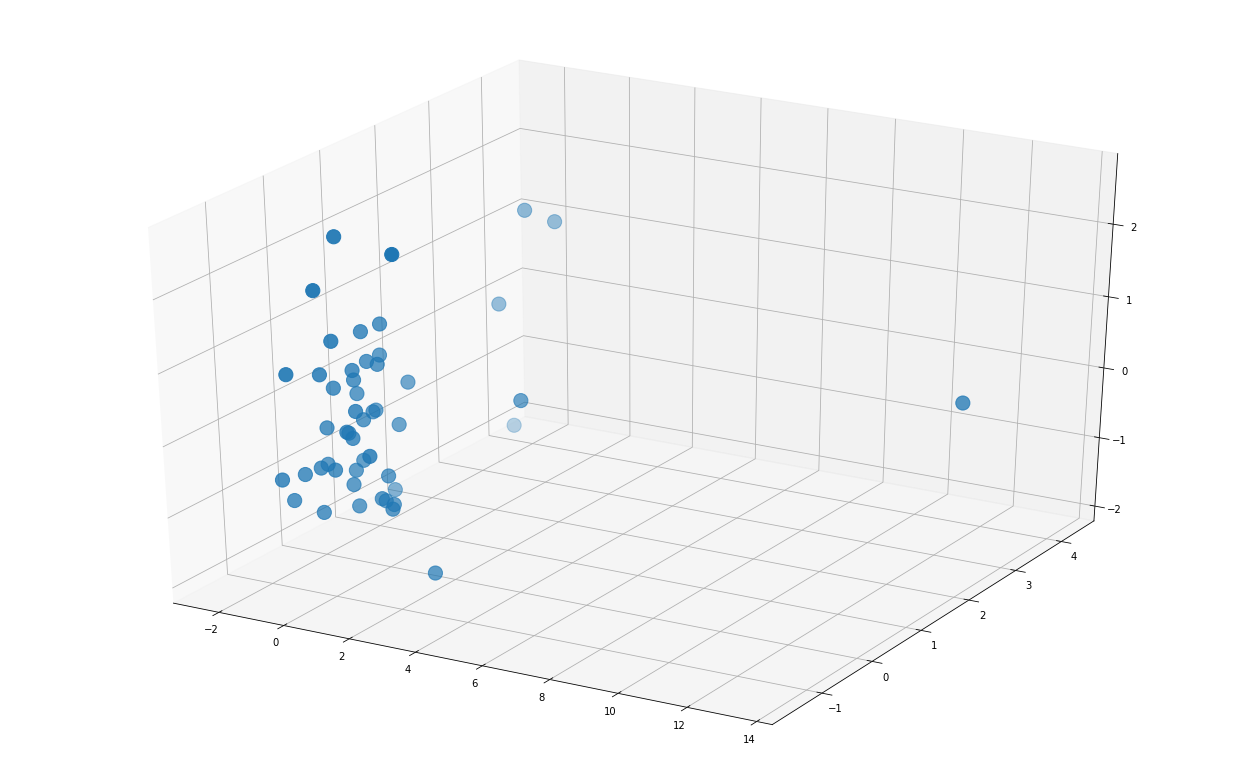

In [38]:
from mpl_toolkits.mplot3d import axes3d
# Create plot
fig = pyplot.figure(figsize=(22,14))
ax = fig.add_subplot(1, 1, 1,projection='3d')
ax.scatter(principalComponents[:,0],principalComponents[:,1],principalComponents[:,2],s=200)

One piece of information that stands out clearly is how much of an outlier California is.  California is a frontrunner and has been for some time, but in order to discern the relationship between the rest of the state we will use kmeans clustering to categorize the rest of the states.  

['AL', 'AR', 'IA', 'ID', 'IN', 'KS', 'KY', 'MS', 'MT', 'NE', 'OK', 'SC', 'SD', 'WV']
['CT', 'DE', 'GA', 'MD', 'ME', 'MI', 'MN', 'MO', 'NC', 'NH', 'OH', 'OR', 'RI', 'TN', 'VA', 'VT', 'WA', 'WI']
['CA']
['FL', 'IL', 'MA', 'NJ', 'NY', 'PA', 'TX']
['AK', 'LA', 'ND', 'WY']
['AZ', 'CO', 'HI', 'NM', 'NV', 'UT']


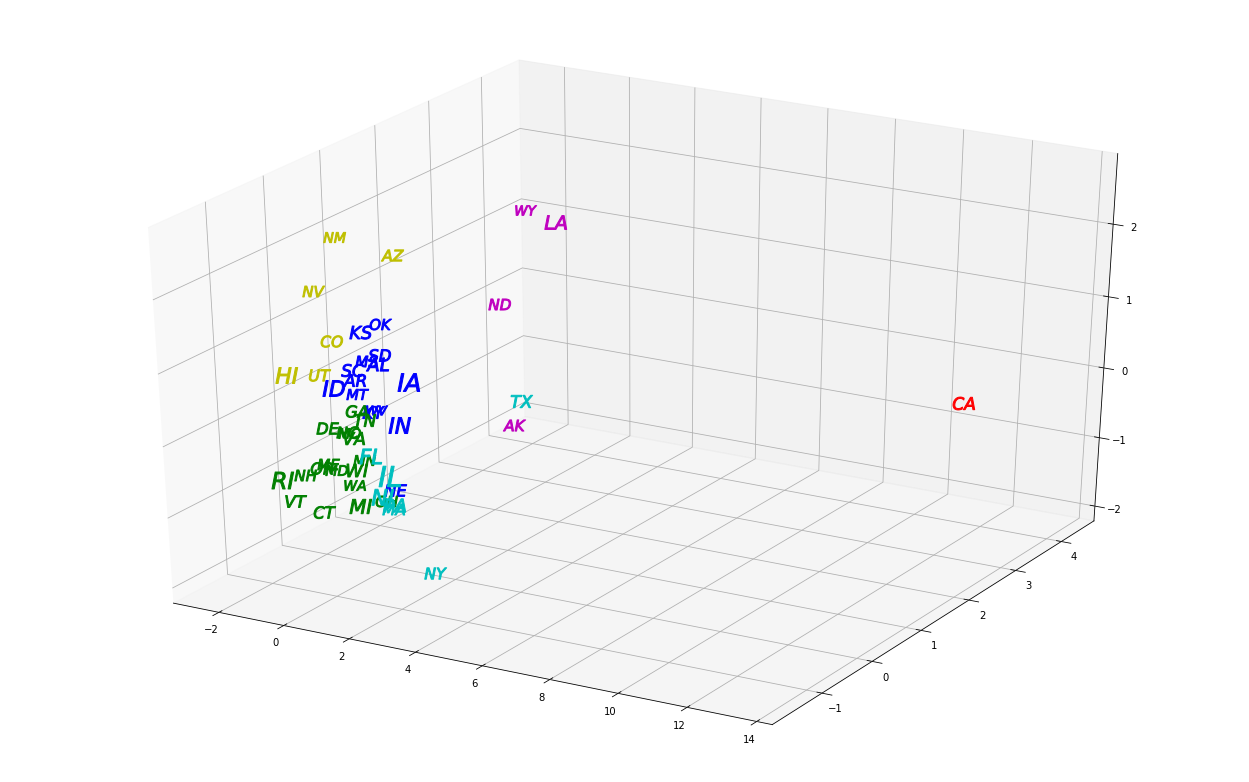

In [85]:
from sklearn.cluster import KMeans
clustnum=6
kmeans = KMeans(n_clusters=clustnum,n_init=50,max_iter=1000)  
kmeans.fit(principalComponents)

fig = pyplot.figure(figsize=(22,14))
ax = fig.add_subplot(1, 1, 1,projection='3d')
cs = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
newslopes = slopes.copy()
allmean = numpy.mean(slopes.values())
for k in range(clustnum):
    stategroup = [kdf.index[x] for x in range(50) if kmeans.labels_[x]==k]
    meanslope = numpy.mean([newslopes[state] for state in newslopes.keys() if state in stategroup])
    for state in stategroup:
        if state not in slopes.keys():
            if numpy.isnan(meanslope):
                newslopes[state] = allmean
            else:
                newslopes[state] = (meanslope + allmean)/2
            
    print stategroup
for i,state in enumerate(kdf.index):
    label = cs[kmeans.labels_[i]]
    mark = '$'+kdf.index[i]+'$'
    ax.scatter(principalComponents[i,0],principalComponents[i,1],principalComponents[i,2],s=500,marker = mark,c=[label])

We have implemented 6 clusters and the groups are somewhat informative.  First it is no surprise that California is its own cluster as it is such an outlier on the plot.  In contrast to california are the non adopters in Purple.  The states off ND, AK, LA, and WY have had so little investment in solar that they stand out together.  The next group in cyan is determined primarily by state econics as well as the investment in solar.  These are states like NJ, MA, TX, FL where there has already been substantial investment in solar energy.  The green group represents a second wave of investment, well consider them latecomers.  The blue group with states like SK, OK, IN are combination of investor in cold areas and places without significant solar investment.  Finally the group with AZ, NM, NV, and others represents the highest insolation of the states.  

In [87]:
labeldict = dict([(kdf.index[i],kmeans.labels_[i]+1)for i in range(50)])
insoldict = kdf.new_insolation.to_dict()
gdpdict = kdf.GDP.to_dict()
# insoldict.items()

roidict = {}
for key in insoldict.keys():
    roidict[key] = newslopes[key]*insoldict[key]
roidict = dict(sorted(roidict.items(), key=lambda kv: -kv[1]))
#roidict

In [88]:
BokehMap(labeldict,0,6,'Kmeans Clusters','')

In [84]:
BokehMap(roidict,1,10,'Power per Dollar','')

We can see a few places to target for investment with rebates.  Rebates in New Hampshire and Maryland seem to have very strong impact on the size of constructed installations.  Nevada and Utah also benefit from this as well as having some of the highest insolation in the country.  New Mexico and Colorado also stand out due to the abundance of sun.